### Set-up

In [1]:
## Run this if using Colab. 
#If not, do the same commands in the computer terminal (without the !)

!pip install git+https://github.com/ficusss/PyGMNormalize.git
!pip install -U scikit-fuzzy

  Cloning https://github.com/ficusss/PyGMNormalize.git to /tmp/pip-req-build-az7tbxp_
  Running command git clone -q https://github.com/ficusss/PyGMNormalize.git /tmp/pip-req-build-az7tbxp_
  Created wheel for pygmnormalize: filename=pygmnormalize-0.2-cp36-none-any.whl size=4669 sha256=061118b2c00b2d1b4d350785de147df8ce8a024fc6eeb6be529d2bf44296b6b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-e_0708v9/wheels/22/f9/56/db07076bd0b3b986414f211fac814066ed164011fbf3596e2e
Successfully built pygmnormalize
     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=0040a8f15dc263c9366edf2f1c4f022165594fe69c6ad3c6b098f48a90950d36
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sb
import pygmnormalize as gmn
from scipy.cluster import hierarchy
from scipy.stats import variation
from skfuzzy.cluster import cmeans, cmeans_predict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data

325 patients; expression data and clinical data

In [0]:
## Use this if running on Colab. Upload files to Colab first
clinical_data = pd.read_csv('clinical_data.csv')
gene_data = pd.read_csv('expression_data.csv')

In [0]:
## Use this if running on Jupyter and have the files in the same directory
# gene_data = pd.read_csv('data/study_1/expression_data.csv')
# clinical_data = pd.read_csv('data/study_1/clinical_data.csv')

#### Sample Data Samples - Expression

In [6]:
gene_data.head()

,Gene_Name,CGGA_1001,CGGA_1006,CGGA_1007,CGGA_1011,CGGA_1015,CGGA_1019,CGGA_1022,CGGA_1023,CGGA_1024,CGGA_1026,CGGA_1034,CGGA_1035,CGGA_1039,CGGA_1045,CGGA_1049,CGGA_1052,CGGA_1072,CGGA_1077,CGGA_1078,CGGA_1079,CGGA_1081,CGGA_1083,CGGA_1091,CGGA_1109,CGGA_1124,CGGA_1139,CGGA_1140,CGGA_1145,CGGA_1171,CGGA_1177,CGGA_1180,CGGA_1188,CGGA_1214,CGGA_1216,CGGA_1218,CGGA_1224,CGGA_1234,CGGA_1237,CGGA_1240,...,CGGA_D39,CGGA_D40,CGGA_D45,CGGA_D46,CGGA_D47,CGGA_D48,CGGA_D52,CGGA_D56,CGGA_D59,CGGA_277,CGGA_518,CGGA_J023,CGGA_J024,CGGA_J042,CGGA_J100,CGGA_1004,CGGA_1008,CGGA_1053,CGGA_1059,CGGA_1070,CGGA_1071,CGGA_1073,CGGA_1074,CGGA_1095,CGGA_1099,CGGA_1114,CGGA_1116,CGGA_1118,CGGA_1119,CGGA_1197,CGGA_1246,CGGA_1275,CGGA_1450,CGGA_1460,CGGA_1475,CGGA_243,CGGA_247,CGGA_738,CGGA_759,CGGA_D30
0,A1BG,12.64,7.03,30.09,6.64,1.83,39.03,12.96,9.28,2.35,3.56,3.18,49.16,9.99,40.35,14.70,4.48,11.04,48.61,13.12,9.59,30.45,18.72,47.06,21.99,10.63,18.90,23.58,9.62,11.87,38.88,55.84,23.07,18.49,18.82,20.02,21.39,6.78,4.97,10.89,...,10.13,17.68,8.97,16.73,9.92,28.25,7.06,21.27,20.50,22.14,7.52,9.38,14.35,21.13,2.24,20.74,15.97,26.36,20.84,5.25,11.83,39.87,20.71,10.94,5.74,13.74,14.75,19.61,21.50,14.90,4.46,28.42,19.32,2.24,18.89,4.03,5.29,4.64,7.07,31.41
1,A1BG-AS1,2.12,1.13,6.64,4.32,1.39,4.46,3.25,1.90,1.22,1.56,0.56,7.75,1.61,9.49,5.02,1.85,2.73,5.59,4.37,2.07,3.78,3.99,5.55,4.27,1.15,2.71,5.00,0.88,2.97,6.18,9.10,1.90,4.85,4.01,5.10,3.61,1.31,0.98,2.95,...,2.99,2.69,2.38,4.89,2.56,3.82,1.03,2.51,2.86,5.46,2.62,1.62,2.14,3.48,0.73,2.23,4.52,2.61,4.16,1.62,1.04,6.93,2.88,2.20,2.41,5.29,1.41,3.19,1.97,2.00,1.57,8.36,2.21,1.60,5.31,2.47,3.69,0.85,1.99,2.65
2,A2M,452.92,106.54,206.70,707.17,824.32,155.14,538.33,26.39,219.35,302.00,139.67,143.45,79.09,202.67,345.41,117.38,126.56,412.72,170.82,136.63,345.27,763.49,235.32,60.24,561.11,61.97,56.12,483.18,614.56,422.29,151.96,67.55,76.20,78.47,234.72,484.48,903.16,134.09,508.32,...,70.55,67.67,115.30,173.03,182.86,116.36,69.12,183.79,248.62,119.77,51.07,94.13,177.72,255.94,125.46,277.46,260.36,298.05,145.93,256.82,214.55,249.91,452.45,276.66,194.31,384.38,174.69,108.87,65.29,78.92,87.20,243.89,73.80,111.50,340.53,108.06,97.24,160.70,263.66,192.54
3,A2M-AS1,3.30,0.13,0.63,1.61,1.34,3.08,0.72,1.96,1.48,0.91,0.40,0.31,0.13,0.40,0.35,0.44,0.37,1.17,0.31,0.24,0.81,2.25,1.41,0.29,0.89,0.60,0.84,0.84,1.44,0.83,1.32,2.07,0.20,0.36,0.93,2.55,0.96,0.63,0.44,...,0.16,0.19,0.27,0.20,0.36,0.38,0.25,0.25,0.38,0.34,0.03,0.19,0.31,0.55,0.11,0.94,0.41,1.90,0.51,1.28,0.41,1.06,3.69,2.32,0.85,1.11,0.38,0.65,0.12,0.15,0.42,1.02,0.22,0.15,0.91,0.33,0.03,0.38,0.48,2.51
4,A2ML1,0.04,0.33,4.96,1.59,0.00,0.10,0.39,2.34,0.68,2.84,0.96,0.13,2.44,2.94,1.06,0.84,0.60,0.25,4.57,7.31,0.18,0.73,0.04,9.13,1.01,5.71,0.69,2.28,1.60,0.00,1.38,0.67,1.25,2.69,0.52,0.34,0.21,1.99,0.48,...,0.51,1.25,1.68,0.38,1.38,0.33,1.10,0.26,1.27,1.04,0.61,0.10,4.07,0.81,0.96,1.04,2.93,0.79,3.33,0.43,0.10,1.02,2.09,3.03,2.74,2.41,3.34,2.40,0.14,0.69,2.58,0.55,0.15,1.75,0.05,1.55,0.71,3.33,0.60,3.86


#### Sample Data Samples - Clinical

In [7]:
clinical_data.head()

,CGGA_ID,PRS_type,Histology,Grade,Gender,Age,OS,Censor,Radio_status,Chemo_status,IDH_mutation_status,1p19q_codeletion_status
0,CGGA_1001,Primary,GBM,WHO IV,Male,11,3428.0,0.0,0.0,1.0,Wildtype,Non-codel
1,CGGA_1006,Primary,AA,WHO III,Male,42,254.0,1.0,1.0,1.0,Wildtype,Non-codel
2,CGGA_1007,Primary,GBM,WHO IV,Female,57,345.0,1.0,1.0,1.0,Wildtype,Non-codel
3,CGGA_1011,Primary,GBM,WHO IV,Female,46,109.0,1.0,1.0,0.0,Wildtype,Non-codel
4,CGGA_1015,Primary,GBM,WHO IV,Male,62,164.0,1.0,1.0,0.0,Wildtype,Non-codel


## Data Exploration

#### Data Dimensions

In [8]:
print(f'Number of Data Samples: {len(gene_data.columns)-1}')
print(f'Number of Genes: {len(gene_data.index)}')

Number of Data Samples: 325
Number of Genes: 24326


### Class (Grade) Distribution

- Impute the class labels (tumor grade) and histology data as some of the values are 'NaN'
- Impute using the most frequent value in the column

In [0]:
class_label_col = ['Grade']
histology_col = ['Histology']

imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')

class_labels = imputer.fit_transform(clinical_data[class_label_col])
histology = imputer.fit_transform(clinical_data[histology_col])

class_labels_categories = list(np.unique(class_labels))

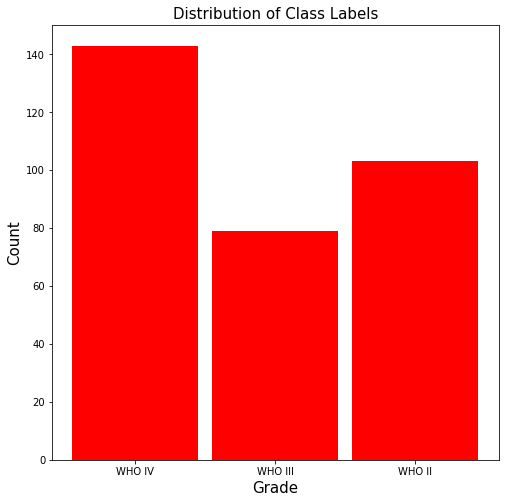

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(class_labels, bins=range(4),  color=['red'], rwidth=0.90, align='left')
ax.set_xlabel('Grade', size=15)
ax.set_ylabel('Count', size=15)
ax.set_title('Distribution of Class Labels', size=15)
plt.show()

In [43]:
unique, counts = np.unique(class_labels, return_counts=True)
print('Counts for labels: ')
for i in range(len(unique)):
    print(f'\t{unique[i]}: {counts[i]}')

Counts for labels: 
	WHO II: 103
	WHO III: 79
	WHO IV: 143


### Histology/Subtype Distribution

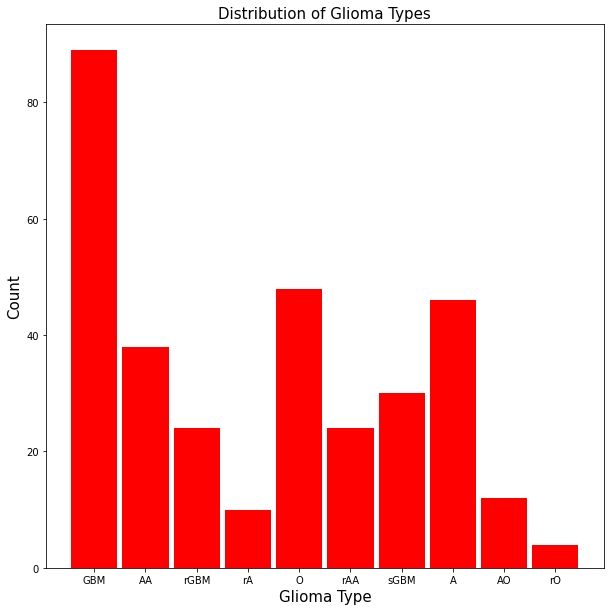

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.hist(histology, bins=range(11),  color=['red'], rwidth=0.90, align='left')
ax.set_xlabel('Glioma Type', size=15)
ax.set_ylabel('Count', size=15)
ax.set_title('Distribution of Glioma Types', size=15)
plt.show()

In [42]:
unique, counts = np.unique(histology, return_counts=True)
print('Counts for glioma subtypes: ')
for i in range(len(unique)):
    print(f'\t{unique[i]}: {counts[i]}')

Counts for glioma subtypes: 
	A: 46
	AA: 38
	AO: 12
	GBM: 89
	O: 48
	rA: 10
	rAA: 24
	rGBM: 24
	rO: 4
	sGBM: 30


### Age Distribution

In [16]:
unique, counts = np.unique(clinical_data['Age'], return_counts=True)
print('Counts for ages: ')
kid = 0
young_adult = 0
adult = 0
senior = 0
for i in range(len(unique)):
    if unique[i] <= 18:
        kid += counts[i]
    elif 18 < unique[i] <= 40:
        young_adult += counts[i]
    elif 40 < unique[i] <= 60:
        adult += counts[i]
    else:
        senior += counts[i]
print(f'\tUnder 18: {kid}')
print(f'\t18 - 40: {young_adult}')
print(f'\t40 - 60: {adult}')
print(f'\tOver 60: {senior}')

Counts for ages: 
	Under 18: 7
	18 - 40: 136
	40 - 60: 158
	Over 60: 24


### Gender Distribution

In [15]:
unique, counts = np.unique(clinical_data['Gender'], return_counts=True)
print('Counts for genders: ')
for i in range(len(unique)):
    print(f'\t{unique[i]}: {counts[i]}')

Counts for genders: 
	Female: 122
	Male: 203


In [37]:
males = clinical_data[clinical_data['Gender']=='Male']
females = clinical_data[clinical_data['Gender']=='Female']

gen_label_col = ['Grade']
imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
males_grade = imputer.fit_transform(males[gen_label_col])
females_grade = imputer.fit_transform(females[gen_label_col])

print(f'\nGrades by gender:')

print(f'Male:')
unique_m, counts_m = np.unique(males_grade, return_counts=True)
for i in range(len(unique_m)):
    print(f'\t{unique_m[i]}: {counts_m[i]}')

print(f'Female:')
unique_f, counts_f = np.unique(females_grade, return_counts=True)
for i in range(len(unique_f)):
    print(f'\t{unique_f[i]}: {counts_f[i]}')

print('\nProportion of Males/Total per Grade:')
print(f'\tWHO II: ', round(counts_m[0]/(counts_m[0] + counts_f[0]),5))
print(f'\tWHO III: ', round(counts_m[1]/(counts_m[1] + counts_f[1]),5))
print(f'\tWHO VI: ', round(counts_m[2]/(counts_m[2] + counts_f[2]),5))


Grades by gender:
Male:
	WHO II: 62
	WHO III: 49
	WHO IV: 92
Female:
	WHO II: 41
	WHO III: 30
	WHO IV: 51

Proportion of Males/Total per Grade:
	WHO II:  0.60194
	WHO III:  0.62025
	WHO VI:  0.64336


*This may cause problems if the model misattributes male charactersitics with malignancy characteristics*

### Visualize Read Counts by Sample

In [0]:
# Store the gene_names in a separate column so that we can work on the gene_data matrix directly
gene_names = gene_data['Gene_Name']
gene_data = gene_data.drop(columns=['Gene_Name'])

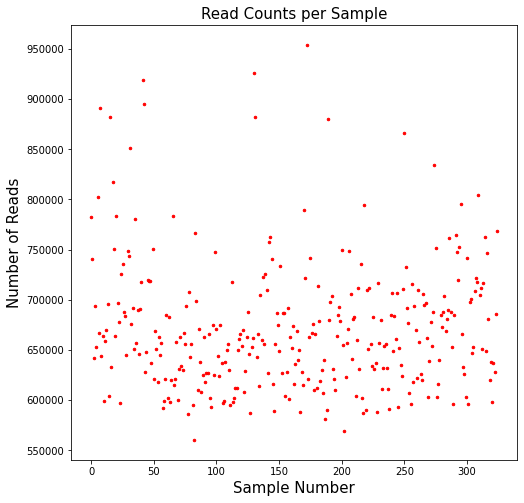

In [0]:
sample_sums = gene_data.sum(axis = 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(range(325), sample_sums, 'r.', markersize=5)
ax.set_xlabel('Sample Number', size=15)
ax.set_ylabel('Number of Reads', size=15)
ax.set_title('Read Counts per Sample', size=15)
plt.show()

### Visualize Read Counts by Gene

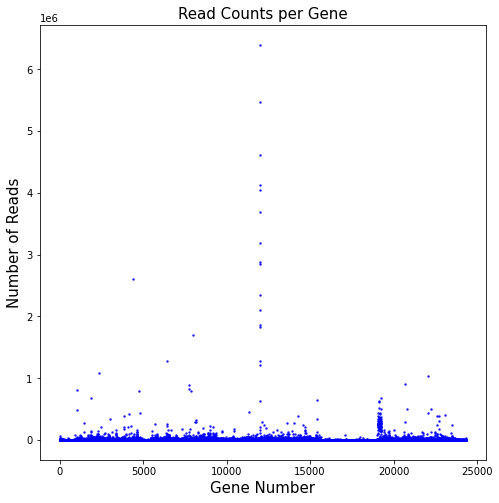

In [0]:
gene_sums = gene_data.sum(axis = 1)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(range(len(gene_sums)), gene_sums, 'b.', alpha = .75, markersize=3)
ax.set_xlabel('Gene Number', size=15)
ax.set_ylabel('Number of Reads', size=15)
ax.set_title('Read Counts per Gene', size=15)
plt.show()

## Train-Test split

In [0]:
# Train-test split 90/10 as this is train/test. 
# stratify=class_labels will make sure that the different classes are equally represented between the training
# and testing data
train_genes, test_genes, train_lbl, test_lbl = train_test_split(gene_data.T, class_labels, 
                                                                test_size=0.10, 
                                                                random_state=0,
                                                                shuffle=True, 
                                                                stratify=class_labels)

## Create Preprocessing Pipeline on Train Data

### Filter based on read count (i.e. 70% of samples have < 1 count for this gene)

In [0]:
low_exp = []
for i in train_genes.columns:
    count = 0
    for j in train_genes[i]:
        if j < 1: 
            count += 1
    if count/325 >= 0.70:
        low_exp.append(i)

In [0]:
cols_filtered = [x for x in train_genes.columns if x not in low_exp]
train_genes = train_genes[cols_filtered]

### Trimmed Mean of M Normalization

In [0]:
# Training Data before applying TMM
train_genes.head()

,0,1,2,4,7,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,28,31,32,33,35,38,39,40,42,43,44,45,47,48,50,52,53,54,55,...,24282,24283,24284,24285,24287,24288,24289,24290,24291,24292,24293,24294,24295,24296,24297,24298,24299,24300,24301,24302,24304,24305,24307,24308,24309,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319,24320,24322,24323,24324,24325
CGGA_171,12.66,1.21,188.46,1.14,1.93,25.41,4.26,7.95,3.18,12.23,2.63,80.28,99.64,17.27,84.17,2.71,63.44,4.74,26.34,1.89,24.75,9.99,92.23,11.66,8.13,4.30,7.04,52.29,17.44,1.33,0.74,4.39,3.59,10.40,4.86,1.38,56.69,9.50,10.62,4.18,...,1.22,1.82,9.71,5.46,2.33,0.71,4.79,18.03,42.40,6.59,0.74,9.38,0.54,0.88,2.45,5.29,6.14,3.82,9.94,3.54,7.55,4.74,3.36,2.54,1.16,3.79,101.39,57.10,0.86,9.90,4.43,2.06,3.90,1.57,3.05,2.68,4.59,35.90,3.56,5.64
CGGA_1024,2.35,1.22,219.35,0.68,4.32,25.78,8.05,6.68,6.91,22.71,4.05,23.22,64.38,21.58,62.23,4.67,14.11,3.14,21.65,10.05,14.01,11.03,64.62,2.70,5.33,2.77,0.49,20.05,35.24,3.57,0.23,2.08,5.55,6.06,4.29,0.86,14.51,13.48,18.28,7.63,...,1.86,0.53,7.90,1.20,3.08,0.26,4.62,6.32,32.99,4.24,1.17,8.78,1.56,1.13,5.05,7.82,10.49,4.05,8.84,4.76,13.25,5.96,2.14,5.79,2.73,4.95,22.05,51.84,0.00,5.95,6.84,6.93,18.18,1.43,3.08,9.56,7.66,147.99,5.79,10.36
CGGA_835,7.11,1.73,82.60,3.43,1.36,36.54,3.99,7.10,4.36,10.29,6.66,37.94,86.70,18.17,64.68,3.35,26.98,5.64,27.62,4.99,23.56,16.95,125.59,1.33,10.82,4.37,3.08,91.61,18.58,1.14,0.61,1.89,9.01,5.84,3.97,0.43,25.18,6.29,11.49,4.21,...,0.68,2.17,7.61,6.91,2.14,2.29,2.93,11.84,36.43,4.75,0.33,8.71,0.85,0.28,3.23,6.44,7.71,3.21,9.67,5.34,9.32,5.07,1.95,5.16,1.92,9.79,40.77,76.34,0.00,6.70,4.49,2.18,5.92,2.14,4.49,6.74,5.21,45.83,4.60,4.43
CGGA_738,4.64,0.85,160.70,3.33,2.69,38.59,8.70,8.09,5.38,9.99,8.77,21.58,66.48,15.06,91.22,6.22,34.98,6.17,22.85,22.54,21.13,15.24,97.35,6.29,15.05,3.57,2.32,55.90,33.28,2.17,2.45,8.01,10.80,15.89,3.75,1.53,25.69,13.40,27.94,3.34,...,2.13,2.70,9.59,2.76,2.46,3.32,5.84,6.95,35.81,7.03,2.51,10.07,1.18,2.90,7.84,15.36,15.79,8.87,13.42,2.65,12.58,7.58,3.81,5.56,3.33,9.19,32.85,60.04,1.07,6.17,3.52,2.85,6.89,2.60,3.89,12.87,9.91,72.42,15.13,12.23
CGGA_479,13.11,2.65,133.27,1.14,6.01,27.09,4.40,7.01,3.63,8.20,3.78,27.87,57.60,14.21,78.23,4.07,26.50,3.59,22.19,12.13,28.88,94.33,106.33,15.66,14.19,3.55,2.53,233.53,30.24,3.71,1.76,3.86,22.20,18.24,3.19,1.06,20.44,7.66,17.06,4.80,...,1.09,2.63,8.23,3.89,2.91,4.81,3.36,6.42,53.43,4.79,0.92,6.92,0.68,2.13,3.45,10.67,12.78,2.77,8.03,1.38,5.07,4.93,1.94,3.04,3.74,8.00,28.26,39.67,0.58,4.41,4.04,3.69,3.80,2.48,3.81,11.88,5.88,51.67,11.34,7.31


In [0]:
# Training data after applying TMM
# Expect genes as rows and samples as columns
normalized_tmm_train_genes = gmn.tmm_normalization(train_genes.T).T
normalized_tmm_train_genes.head()

,0,1,2,4,7,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,28,31,32,33,35,38,39,40,42,43,44,45,47,48,50,52,53,54,55,...,24282,24283,24284,24285,24287,24288,24289,24290,24291,24292,24293,24294,24295,24296,24297,24298,24299,24300,24301,24302,24304,24305,24307,24308,24309,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319,24320,24322,24323,24324,24325
CGGA_171,18.586436,1.776429,276.682446,1.673660,2.833477,37.305003,6.254204,11.671577,4.668631,17.955143,3.861163,117.860908,146.283768,25.354483,123.571906,3.978613,93.137718,6.958903,38.670358,2.774752,36.336042,14.666548,135.404977,17.118313,11.935839,6.312929,10.335585,76.768148,25.604064,1.952603,1.086411,6.445060,5.270561,15.268478,7.135077,2.026010,83.227888,13.947168,15.591465,6.136754,...,1.791110,2.671984,14.255474,8.015951,3.420726,1.042367,7.032309,26.470256,62.248412,9.674930,1.086411,13.770993,0.792786,1.291948,3.596901,7.766370,9.014275,5.608230,14.593142,5.197155,11.084328,6.958903,4.932893,3.729032,1.703023,5.564186,148.852983,83.829819,1.262586,14.534417,6.503785,3.024333,5.725679,2.304953,4.477775,3.934569,6.738684,52.705613,5.226518,8.280213
CGGA_1024,2.436149,1.264724,227.391214,0.704928,4.478368,26.725076,8.345107,6.924884,7.163316,23.542532,4.198470,24.071229,66.740125,22.371107,64.511307,4.841199,14.627263,3.255110,22.443674,10.418426,14.523597,11.434352,66.988923,2.798980,5.525394,2.871546,0.507963,20.785019,36.531873,3.700874,0.238432,2.156251,5.753459,6.282155,4.447268,0.891527,15.041926,13.974167,18.950132,7.909710,...,1.928186,0.549429,8.189608,1.243991,3.192911,0.269531,4.789366,6.551687,34.199390,4.395435,1.212891,9.101869,1.617188,1.171425,5.235129,8.106676,10.874556,4.198470,9.164068,4.934498,13.735736,6.178489,2.218451,6.002257,2.830080,5.131463,22.858337,53.740417,0.000000,6.168123,7.090750,7.184049,18.846466,1.482423,3.192911,9.910463,7.940810,153.415208,6.002257,10.739790
CGGA_835,8.503976,2.069181,98.794437,4.102481,1.626640,43.703980,4.772274,8.492016,5.214815,12.307443,7.965750,45.378462,103.698277,21.732384,77.361068,4.006796,32.269660,6.745770,33.035138,5.968332,28.179140,20.273193,150.212995,1.590758,12.941354,5.226776,3.683860,109.570925,22.222768,1.363507,0.729596,2.260551,10.776488,6.984982,4.748352,0.514305,30.116755,7.523208,13.742713,5.035407,...,0.813320,2.595447,9.102006,8.264765,2.559565,2.738974,3.504452,14.161333,43.572413,5.681278,0.394699,10.417670,1.016650,0.334896,3.863269,7.702617,9.221612,3.839348,11.565886,6.386953,11.147266,6.064017,2.332314,6.171662,2.296432,11.709413,48.763308,91.307111,0.000000,8.013592,5.370303,2.607408,7.080667,2.559565,5.370303,8.061435,6.231465,54.815364,5.501869,5.298539
CGGA_738,4.307423,0.789075,149.181639,3.091318,2.497191,35.824017,8.076417,7.510140,4.994382,9.273955,8.141400,20.033228,61.714968,13.980557,84.681700,5.774174,32.472768,5.727758,21.212199,20.924419,19.615483,14.147655,90.372325,5.839157,13.971274,3.314116,2.153711,51.893302,30.894617,2.014463,2.274393,7.435874,10.025897,14.751066,3.481214,1.420335,23.848639,12.439539,25.937368,3.100602,...,1.977330,2.506474,8.902626,2.562174,2.283677,3.082035,5.421411,6.451851,33.243276,6.526117,2.330093,9.348221,1.095422,2.692139,7.278059,14.259054,14.658233,8.234232,12.458106,2.460058,11.678314,7.036695,3.536914,5.161480,3.091318,8.531296,30.495438,55.736563,0.993306,5.727758,3.267700,2.645723,6.396151,2.413642,3.611180,11.947528,9.199689,67.229212,14.045540,11.353400
CGGA_479,16.415838,3.318228,166.875575,1.427464,7.525491,33.921058,5.509511,8.777653,4.545347,10.267725,4.733171,34.897744,72.124508,17.793216,97.956601,5.096298,33.182282,4.495260,27.785466,15.188720,36.162427,118.116403,133.142342,19.608851,17.768173,4.445174,3.167969,292.417297,37.865367,4.645520,2.203804,4.833344,27.797987,22.839427,3.994395,1.327291,25.594183,9.591558,21.361877,6.010376,...,1.364856,3.293185,10.305290,4.870909,3.643790,6.022897,4.207263,8.038877,66.902994,5.997854,1.151989,8.664958,0.851470,2.667104,4.319957,13.360564,16.002625,3.468488,10.054858,1.72

In [0]:
gene_indices = list(normalized_tmm_train_genes.columns.values) 

### Log Transformation


In [0]:
log_normalized_tmm_train_genes = pd.DataFrame(np.log2(normalized_tmm_train_genes, out=np.zeros_like(normalized_tmm_train_genes), where=(normalized_tmm_train_genes!=0)))
log_normalized_tmm_train_genes.columns = gene_indices
log_normalized_tmm_train_genes.head()

,0,1,2,4,7,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,28,31,32,33,35,38,39,40,42,43,44,45,47,48,50,52,53,54,55,...,24282,24283,24284,24285,24287,24288,24289,24290,24291,24292,24293,24294,24295,24296,24297,24298,24299,24300,24301,24302,24304,24305,24307,24308,24309,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319,24320,24322,24323,24324,24325
0,4.216178,0.828980,8.112087,0.743007,1.502574,5.221297,2.644826,3.544928,2.223000,4.166325,1.949036,6.880941,7.192626,4.664169,6.949207,1.992266,6.541294,2.798860,5.273156,1.472359,5.183329,3.874457,7.081137,4.097469,3.577228,2.658309,3.369548,6.262436,4.678301,0.965399,0.119570,2.688194,2.397957,3.932484,2.834929,1.018641,6.378995,3.801900,3.962685,2.617476,...,0.840854,1.417911,3.833444,3.002874,1.774303,0.059864,2.813998,4.726300,5.959965,3.274251,0.119570,3.783561,-0.334996,0.369548,1.846755,2.957240,3.172211,2.487545,3.867219,2.377722,3.470449,2.798860,2.302434,1.898801,0.768098,2.476171,7.217744,6.389392,0.336381,3.861401,2.701279,1.596617,2.517447,1.204737,2.162782,1.976206,2.752467,5.719885,2.385850,3.049668
1,1.284603,0.338823,7.829033,-0.504452,2.162973,4.740122,3.060931,2.791790,2.840628,4.557198,2.069864,4.589238,6.060482,4.483565,6.011480,2.275364,3.870588,1.702706,4.488237,3.381065,3.860327,3.515303,6.065851,1.484901,2.466077,1.521828,-0.977205,4.377472,5.191084,1.887866,-2.068352,1.108525,2.524430,2.651260,2.152919,-0.165650,3.910917,3.804690,4.244136,2.983625,...,0.947244,-0.863994,3.033794,0.314976,1.674872,-1.891475,2.259835,2.711866,5.095899,2.136006,0.278450,3.186163,0.693488,0.228265,2.388225,3.019110,3.442885,2.069864,3.195988,2.302903,3.779862,2.627254,1.149553,2.585505,1.500843,2.359370,4.514649,5.747936,0.000000,2.624831,2.825938,2.844797,4.236222,0.567957,1.674872,3.308952,2.989286,7.261298,2.585505,3.424894
2,3.088138,1.049060,6.626358,2.036497,0.701895,5.449693,2.254677,3.086107,2.382616,3.621459,2.993810,5.503936,6.696248,4.441775,6.273536,2.002449,5.012106,2.753983,5.045929,2.577328,4.816556,4.341501,7.230866,0.669714,3.693917,2.385921,1.881218,6.775721,4.473967,0.447322,-0.454831,1.176674,3.429815,2.804256,2.247427,-0.959303,4.912494,2.911348,3.780595,2.332108,...,-0.298105,1.375983,3.186184,3.046974,1.355899,1.453636,1.809189,3.823885,5.445343,2.506216,-1.341174,3.380961,0.023823,-1.578213,1.949822,2.945349,3.205019,1.940861,3.531804,2.675128,3.478618,2.600274,1.221762,2.625659,1.199394,3.549597,5.607724,6.512655,0.000000,3.002449,2.425003,1.382616,2.823885,1.355899,2.425003,3.011037,2.639571,5.776508,2.459922,2.405595
3,2.106825,-0.341765,7.220926,1.628222,1.320306,5.162855,3.013715,2.908840,2.320306,3.213185,3.025277,4.324323,5.947549,3.805350,6.403978,2.529615,5.021158,2.517971,4.406822,4.387116,4.293921,3.822491,6.497809,2.545760,3.804392,1.728624,1.106825,5.697476,4.949284,1.010395,1.185482,2.894502,3.325659,3.882747,1.799591,0.506232,4.575835,3.636861,4.696960,1.632548,...,0.983553,1.325659,3.154231,1.357368,1.191358,1.623883,2.438668,2.689713,5.054991,2.706225,1.220387,3.224692,0.131487,1.428753,2.863554,3.833806,3.873639,3.041634,3.639013,1.298692,3.545760,2.814898,1.822491,2.367785,1.628222,3.092765,4.930522,5.800552,-0.009689,2.517971,1.708275,1.403662,2.677204,1.271212,1.852470,3.578640,3.201585,6.071016,3.812040,3.505053
4,4.037017,1.730413,7.382629,0.513455,2.911786,5.084109,2.461924,3.133835,2.184390,3.360045,2.242807,5.125062,6.172418,4.153255,6.614071,2.349450,5.052341,2.168405,4.796259,3.924928,5.176420,6.884066,7.056826,4.293433,4.151223,2.152240,1.663558,8.191885,5.242807,2.215840,1.139996,2.273022,4.796909,4.513455,1.997977,0.408485,4.677744,3.261765,4.416966,2.587455,...,0.448749,1.719484,3.365313,2.284191,1.865440,2.590458,2.072882,3.006994,6.063999,2.584446,0.204127,3.115193,-0.231973,1.415274,2.111017,3.739909,4.000237,1.794307,3.329821,0.789089,2.666407,2.626008,1.280477,1.928492,2.227459,3.324421,5.145110,5.634397,-0.461454,2.465199,2.338776,2.208042,2.250420,1.634761,2.254212,3.894884,2.880237,6.015676,3.827769,3.19

#### Visualize Distribution of Counts per Gene after Normalized and Log-transformed

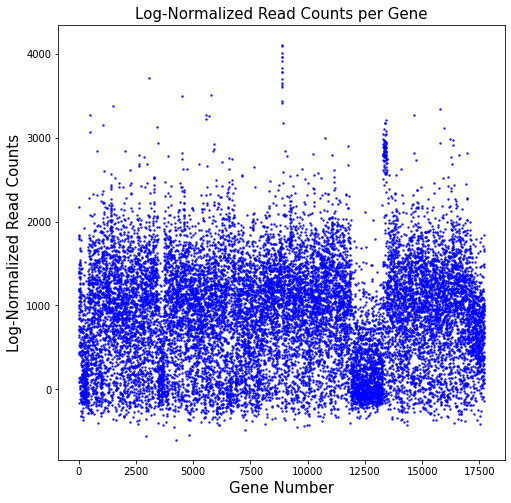

In [0]:
log_norm_sums = log_normalized_tmm_train_genes.sum(axis = 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(range(len(log_norm_sums)), log_norm_sums, 'b.', alpha = .75, markersize=3)
ax.set_xlabel('Gene Number', size=15)
ax.set_ylabel('Log-Normalized Read Counts', size=15)
ax.set_title('Log-Normalized Read Counts per Gene', size=15)
plt.show()

### Selecting Features based on Variance

#### Visualize Variance

In [0]:
selector = VarianceThreshold(threshold=0.5)
high_var_train_genes = pd.DataFrame(selector.fit_transform(log_normalized_tmm_train_genes))

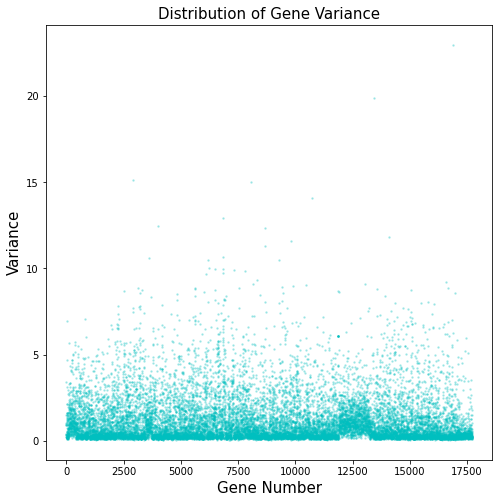

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(selector.variances_, 'c.', alpha=0.25, markersize=3)
ax.set_xlabel('Gene Number', size=15)
ax.set_ylabel('Variance', size=15)
ax.set_title('Distribution of Gene Variance', size=15)
plt.show()

#### Close-up of the distribution

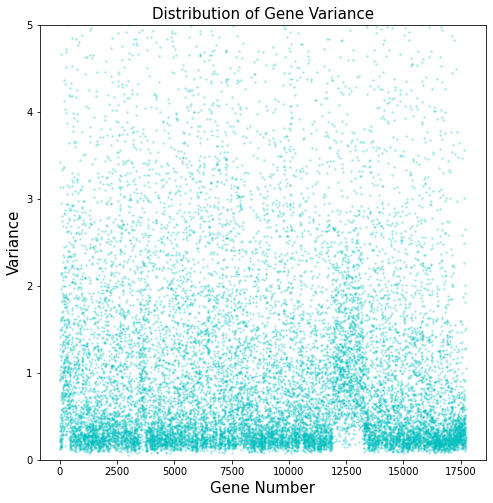

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(selector.variances_, 'c.', alpha=0.25, markersize=3)
ax.set_xlabel('Gene Number', size=15)
ax.set_ylabel('Variance', size=15)
ax.set_ylim(bottom=0, top = 5)
ax.set_title('Distribution of Gene Variance', size=15)
plt.show()

#### Remove Genes with Low Variance

In [0]:
## Note: Already fit the VarianceThreshold with the visualizations above

#create a mask of features selected
mask = selector.get_support(indices = True)

#select the same indexes from the header
reduced_header = np.take(gene_indices, mask)

high_var_train_genes.columns = reduced_header

print(f"Filter reduced number of genes by {len(log_normalized_tmm_train_genes.columns) - len(high_var_train_genes.columns)} from {len(log_normalized_tmm_train_genes.columns)} to {len(high_var_train_genes.columns)}")
high_var_train_genes.head()

Filter reduced number of genes by 7781 from 17717 to 9936


,0,1,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,77,78,79,82,86,88,89,96,98,102,103,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,4.216178,0.828980,8.112087,0.743007,1.502574,1.949036,3.874457,7.081137,4.097469,3.577228,3.369548,6.262436,0.965399,0.119570,2.688194,2.397957,3.932484,1.018641,2.617476,1.195519,1.678301,2.059864,1.441498,0.353060,2.600115,6.097778,0.910117,1.997579,0.780481,3.653268,4.198983,0.495079,1.479972,0.730296,6.285156,0.898801,4.378741,4.320568,4.560271,4.237669,...,1.596617,-0.135687,2.332181,0.582542,1.749320,2.684904,3.543112,1.276439,0.158044,4.227529,1.596617,1.852631,1.441498,-2.389444,-0.207240,-0.880430,4.119570,2.921344,0.678301,-0.732331,3.568328,1.553973,0.553973,1.943540,1.393932,1.810983,-1.089883,0.000000,1.018641,1.417911,3.002874,0.059864,5.959965,0.369548,1.898801,0.768098,0.336381,1.596617,2.517447,5.719885
1,1.284603,0.338823,7.829033,-0.504452,2.162973,2.069864,3.515303,6.065851,1.484901,2.466077,-0.977205,4.377472,1.887866,-2.068352,1.108525,2.524430,2.651260,-0.165650,2.983625,2.069864,3.652449,1.182873,-1.382461,0.108525,0.408086,0.149553,1.419313,2.474175,0.266067,2.326949,3.837492,-0.084120,1.129185,-0.810555,3.564169,-1.504452,2.981733,5.905189,4.365913,4.091957,...,2.725498,0.915880,1.632087,-3.591914,2.895926,2.983625,3.212217,2.542512,0.915880,3.245714,0.362282,3.022795,0.808965,0.993048,-0.863994,-0.343987,-1.462631,3.340300,-0.052756,-0.234362,3.601611,0.240976,0.954980,2.972235,-5.591914,1.597910,-0.547520,0.646490,0.516610,-0.863994,0.314976,-1.891475,5.095899,0.228265,2.585505,1.500843,0.000000,2.844797,4.236222,7.261298
2,3.088138,1.049060,6.626358,2.036497,0.701895,2.993810,4.341501,7.230866,0.669714,3.693917,1.881218,6.775721,0.447322,-0.454831,1.176674,3.429815,2.804256,-0.959303,2.332108,1.236484,-1.298105,2.625659,0.258288,0.521322,1.122226,4.837830,1.728174,2.247427,0.963160,4.262789,3.552541,-0.713143,2.375983,0.447322,5.775249,0.927315,4.345751,4.108287,4.883559,4.531804,...,1.608785,-2.385568,1.122226,-0.045718,2.605954,3.208756,2.998136,2.180486,0.328677,1.106285,-0.959303,1.603117,0.057375,0.733373,-0.431372,-0.830979,3.746289,3.247427,0.909053,-2.385568,2.878874,0.073863,0.355899,2.725568,1.057375,1.963160,-0.454831,1.161326,-2.137641,1.375983,3.046974,1.453636,5.445343,-1.578213,2.625659,1.199394,0.000000,1.382616,2.823885,5.776508
3,2.106825,-0.341765,7.220926,1.628222,1.320306,3.025277,3.822491,6.497809,2.545760,3.804392,1.106825,5.697476,1.010395,1.185482,2.894502,3.325659,3.882747,0.506232,1.632548,2.298692,1.320306,2.013715,-0.036911,1.487249,-0.844266,3.788003,0.928324,2.677204,-0.706762,4.018682,3.469222,1.030204,0.949284,-1.023236,3.558320,1.265652,3.528454,5.152726,4.540015,3.350820,...,1.952747,0.700055,0.477663,0.003731,1.952747,3.478864,3.227554,1.910622,0.997037,0.885468,1.413751,2.724577,1.708275,1.570772,-0.107300,0.561727,1.712368,3.806308,1.243197,-0.078731,2.116123,1.649723,0.649723,1.776321,-4.429228,2.396049,-0.642632,1.756639,-1.259303,1.325659,1.357368,1.623883,5.054991,1.428753,2.367785,1.628222,-0.009689,1.403662,2.677204,6.071016
4,4.037017,1.730413,7.382629,0.513455,2.911786,2.242807,6.884066,7.056826,4.293433,4.151223,1.663558,8.191885,2.215840,1.139996,2.273022,4.796909,4.513455,0.408485,2.587455,2.387924,-2.071508,2.204127,0.235153,-0.461454,1.487919,4.568547,3.416966,2.072882,1.257993,4.040314,4.756712,-0.795873,-0.297068,1.115193,4.427079,0.646349,4.772000,4.322616,4.823948,3.579921,...,1.652108,0.394810,0.956689,-0.169688,2.921356,3.182402,3.267404,1.227459,0.984345,2.428757,-0.365239,2.320810,-0.275041,-1.109982,1.317189,0.055604,1.046887,3.521342,1.550929,0.020415,3.004745,0.408485,0.550929,2.215840,0.928492,1.933230,-0.734473,0.918969,-1.275041,1.719484,2.284191,2.590458,6.063999,1.415274,1.92

#### Remove highly correlated features
- This can decrease the dimensionality of the data while eliminating redundancy

In [0]:
cov = abs(high_var_train_genes.corr().to_numpy())

In [0]:
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype=int)
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.show()

In [0]:
filtered_cov_high_var = []
for i in range(len(high_var_train_genes.columns)):
    row = []
    for j in range(len(high_var_train_genes.columns)):
        if cov[i][j] > 0.70 and i != j:
            row.append(j)
    filtered_cov_high_var.append(row)

In [0]:
filtered = []
for i in range(len(filtered_cov_high_var)):
    if len(filtered_cov_high_var[i]) > 0:
        filtered.append(i)

In [0]:
to_remove = []
to_keep = []
for gene in filtered:
    # The gene is not correlated to anything we've seen so far
    if gene not in to_remove:
        # remove all values 
        vals = filtered_cov_high_var[gene]
        for val in vals:
            if val not in to_remove:
                to_remove.append(val)
        to_keep.append(gene)

###### Get the new filtered features

In [0]:
cols_filtered = [x for x in high_var_train_genes.columns if x not in to_remove]

In [0]:
high_var_train_genes = high_var_train_genes[cols_filtered]

###### Plot the new matrix

In [0]:
cov = abs(high_var_train_genes[cols_filtered].corr().to_numpy())

In [0]:
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype=int)
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.show()

In [0]:
high_var_train_genes.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,4.216178,8.112087,0.743007,1.502574,1.949036,3.874457,7.081137,4.097469,3.577228,3.369548,6.262436,0.965399,0.119570,2.688194,2.397957,3.932484,1.018641,2.617476,1.195519,1.678301,2.059864,1.441498,0.353060,2.600115,6.097778,0.910117,1.997579,0.780481,4.198983,0.495079,1.479972,0.730296,6.285156,0.898801,4.378741,4.320568,4.560271,4.237669,2.898801,3.731891,...,1.596617,-0.135687,2.332181,0.582542,1.749320,2.684904,3.543112,1.276439,0.158044,4.227529,1.596617,1.852631,1.441498,-2.389444,-0.207240,-0.880430,4.119570,2.921344,0.678301,-0.732331,3.568328,1.553973,0.553973,1.943540,1.393932,1.810983,-1.089883,0.000000,1.018641,1.417911,3.002874,0.059864,5.959965,0.369548,1.898801,0.768098,0.336381,1.596617,2.517447,5.719885
1,1.284603,7.829033,-0.504452,2.162973,2.069864,3.515303,6.065851,1.484901,2.466077,-0.977205,4.377472,1.887866,-2.068352,1.108525,2.524430,2.651260,-0.165650,2.983625,2.069864,3.652449,1.182873,-1.382461,0.108525,0.408086,0.149553,1.419313,2.474175,0.266067,3.837492,-0.084120,1.129185,-0.810555,3.564169,-1.504452,2.981733,5.905189,4.365913,4.091957,3.085805,2.244136,...,2.725498,0.915880,1.632087,-3.591914,2.895926,2.983625,3.212217,2.542512,0.915880,3.245714,0.362282,3.022795,0.808965,0.993048,-0.863994,-0.343987,-1.462631,3.340300,-0.052756,-0.234362,3.601611,0.240976,0.954980,2.972235,-5.591914,1.597910,-0.547520,0.646490,0.516610,-0.863994,0.314976,-1.891475,5.095899,0.228265,2.585505,1.500843,0.000000,2.844797,4.236222,7.261298
2,3.088138,6.626358,2.036497,0.701895,2.993810,4.341501,7.230866,0.669714,3.693917,1.881218,6.775721,0.447322,-0.454831,1.176674,3.429815,2.804256,-0.959303,2.332108,1.236484,-1.298105,2.625659,0.258288,0.521322,1.122226,4.837830,1.728174,2.247427,0.963160,3.552541,-0.713143,2.375983,0.447322,5.775249,0.927315,4.345751,4.108287,4.883559,4.531804,2.286857,4.448113,...,1.608785,-2.385568,1.122226,-0.045718,2.605954,3.208756,2.998136,2.180486,0.328677,1.106285,-0.959303,1.603117,0.057375,0.733373,-0.431372,-0.830979,3.746289,3.247427,0.909053,-2.385568,2.878874,0.073863,0.355899,2.725568,1.057375,1.963160,-0.454831,1.161326,-2.137641,1.375983,3.046974,1.453636,5.445343,-1.578213,2.625659,1.199394,0.000000,1.382616,2.823885,5.776508
3,2.106825,7.220926,1.628222,1.320306,3.025277,3.822491,6.497809,2.545760,3.804392,1.106825,5.697476,1.010395,1.185482,2.894502,3.325659,3.882747,0.506232,1.632548,2.298692,1.320306,2.013715,-0.036911,1.487249,-0.844266,3.788003,0.928324,2.677204,-0.706762,3.469222,1.030204,0.949284,-1.023236,3.558320,1.265652,3.528454,5.152726,4.540015,3.350820,4.756639,3.470431,...,1.952747,0.700055,0.477663,0.003731,1.952747,3.478864,3.227554,1.910622,0.997037,0.885468,1.413751,2.724577,1.708275,1.570772,-0.107300,0.561727,1.712368,3.806308,1.243197,-0.078731,2.116123,1.649723,0.649723,1.776321,-4.429228,2.396049,-0.642632,1.756639,-1.259303,1.325659,1.357368,1.623883,5.054991,1.428753,2.367785,1.628222,-0.009689,1.403662,2.677204,6.071016
4,4.037017,7.382629,0.513455,2.911786,2.242807,6.884066,7.056826,4.293433,4.151223,1.663558,8.191885,2.215840,1.139996,2.273022,4.796909,4.513455,0.408485,2.587455,2.387924,-2.071508,2.204127,0.235153,-0.461454,1.487919,4.568547,3.416966,2.072882,1.257993,4.756712,-0.795873,-0.297068,1.115193,4.427079,0.646349,4.772000,4.322616,4.823948,3.579921,2.192317,5.387061,...,1.652108,0.394810,0.956689,-0.169688,2.921356,3.182402,3.267404,1.227459,0.984345,2.428757,-0.365239,2.320810,-0.275041,-1.109982,1.317189,0.055604,1.046887,3.521342,1.550929,0.020415,3.004745,0.408485,0.550929,2.215840,0.928492,1.933230,-0.734473,0.918969,-1.275041,1.719484,2.284191,2.590458,6.063999,1.415274,1.

## Apply Preprocessing Pipeline to Test Data

In [0]:
# Testing Data before applying TMM
test_genes.head()

,0,1,2,4,7,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,28,31,32,33,35,38,39,40,42,43,44,45,47,48,50,52,53,54,55,...,24282,24283,24284,24285,24287,24288,24289,24290,24291,24292,24293,24294,24295,24296,24297,24298,24299,24300,24301,24302,24304,24305,24307,24308,24309,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319,24320,24322,24323,24324,24325
CGGA_747,13.15,2.36,114.84,1.36,1.18,59.20,6.66,12.63,4.84,11.29,6.26,17.50,65.84,20.04,79.47,6.32,31.03,9.99,30.03,13.28,37.84,5.28,82.41,8.23,6.43,5.14,0.66,40.82,33.86,1.26,0.35,3.61,5.92,5.12,3.42,1.70,31.23,14.48,13.77,1.40,...,2.25,0.43,9.13,3.84,5.27,0.41,6.85,3.92,38.26,6.90,1.63,9.30,1.13,3.03,7.10,16.85,11.45,4.83,9.87,4.34,12.40,11.02,2.73,10.28,1.05,23.88,22.18,169.12,0.44,5.99,7.58,5.83,44.67,3.34,5.03,17.74,8.42,97.58,17.90,20.35
CGGA_1320,10.64,3.94,33.99,2.82,1.47,53.74,4.26,5.10,11.60,12.27,20.75,30.73,58.54,9.72,56.40,3.97,43.36,6.22,21.80,23.45,23.02,11.36,123.97,26.05,14.18,7.71,3.60,81.55,14.22,35.24,0.33,1.75,2.08,7.54,4.26,1.18,74.98,5.47,9.17,3.91,...,1.49,9.69,21.11,18.46,1.37,1.07,4.81,4.50,147.65,4.69,0.63,13.47,1.81,0.35,5.62,6.55,15.30,1.56,7.72,16.78,8.27,3.88,1.07,5.75,1.02,6.84,33.71,179.14,7.39,3.99,2.43,3.70,16.48,1.51,1.05,9.31,3.92,60.85,6.87,8.74
CGGA_760,3.99,1.10,81.73,1.28,3.48,29.48,7.02,5.69,3.09,8.99,6.37,19.45,59.26,14.14,67.61,4.39,19.10,3.91,23.42,6.15,21.37,52.74,165.86,22.09,4.42,1.67,2.41,155.23,34.43,2.17,1.29,2.47,9.15,5.69,2.38,0.62,19.24,6.38,14.40,4.75,...,0.98,1.96,6.96,4.47,2.29,2.51,2.11,4.96,41.45,3.58,0.57,6.39,0.92,1.15,3.31,6.53,7.53,2.51,7.28,2.10,5.61,5.29,1.44,2.51,1.80,12.73,18.07,46.90,0.00,4.03,5.04,2.08,2.57,2.51,4.45,10.72,5.64,43.71,10.47,6.10
CGGA_538,6.02,2.28,85.14,3.19,1.97,33.14,7.71,7.36,3.45,11.14,5.62,30.61,76.84,17.40,80.96,5.91,30.41,6.10,31.16,12.03,22.15,33.11,151.11,11.35,14.91,3.43,2.46,93.15,26.74,2.24,0.90,5.18,24.03,8.12,4.04,0.90,25.23,9.45,16.56,3.72,...,1.49,2.77,6.88,3.80,3.85,8.75,3.20,6.14,38.00,6.27,1.56,10.39,0.97,5.10,5.47,14.49,12.59,8.23,11.85,3.24,8.88,6.21,3.07,6.48,3.47,8.40,25.68,55.03,0.91,6.28,4.59,2.81,4.17,3.69,4.25,9.90,6.92,29.07,15.45,7.97
CGGA_909,3.76,1.35,73.51,3.66,1.76,37.69,5.31,11.02,4.76,10.61,4.93,25.59,71.01,13.94,81.34,5.98,33.18,6.71,29.74,15.80,17.35,26.78,198.63,2.08,17.04,4.06,3.68,74.21,33.63,2.26,1.60,6.97,9.52,12.73,4.42,1.78,29.87,8.76,29.48,4.32,...,1.78,1.56,5.91,2.16,4.47,5.27,2.45,6.96,38.08,6.81,1.90,14.48,1.00,4.66,8.03,14.12,11.44,6.45,15.36,3.21,10.15,6.36,3.67,5.72,2.81,12.11,32.51,56.69,1.28,7.85,4.84,3.05,5.78,2.89,4.38,10.17,5.73,60.01,18.22,8.15


#### Filter low expression columns determined by training data

In [0]:
cols_filtered = [x for x in test_genes.columns if x not in low_exp]
test_genes = test_genes[cols_filtered]

#### Normalize and log transform the test data

In [0]:
# Testing data after applying TMM
# Expect genes as rows and samples as columns
normalized_tmm_test_genes = gmn.tmm_normalization(test_genes.T).T
normalized_tmm_test_genes.head()

,0,1,2,4,7,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,28,31,32,33,35,38,39,40,42,43,44,45,47,48,50,52,53,54,55,...,24282,24283,24284,24285,24287,24288,24289,24290,24291,24292,24293,24294,24295,24296,24297,24298,24299,24300,24301,24302,24304,24305,24307,24308,24309,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319,24320,24322,24323,24324,24325
CGGA_747,13.161391,2.362044,114.939478,1.361178,1.181022,59.251281,6.665769,12.640940,4.844193,11.299780,6.265423,17.515159,65.897033,20.057359,79.538839,6.325475,31.056879,9.998654,30.056013,13.291504,37.872778,5.284574,82.481386,8.237129,6.435570,5.144452,0.660572,40.855360,33.889331,1.261091,0.350303,3.613127,5.925128,5.124435,3.422963,1.701473,31.257052,14.492543,13.781928,1.401213,...,2.251949,0.430372,9.137909,3.843326,5.274565,0.410355,6.855934,3.923396,38.293142,6.905977,1.631412,9.308056,1.130979,3.032625,7.106150,16.864596,11.459918,4.834184,9.878550,4.343759,12.410741,11.029546,2.732365,10.288905,1.050910,23.900686,22.199213,169.266497,0.440381,5.995189,7.586566,5.835050,44.708695,3.342893,5.034357,17.755367,8.427294,97.664527,17.915506,20.367628
CGGA_1320,10.489705,3.884346,33.509877,2.780166,1.449236,52.980899,4.199826,5.027960,11.436145,12.096681,20.456897,30.295926,57.713097,9.582701,55.603326,3.913922,42.747521,6.132140,21.492066,23.118759,22.694833,11.199535,122.218871,25.682033,13.979701,7.601093,3.549148,80.398071,14.019136,34.742220,0.325339,1.725281,2.050619,7.433494,4.199826,1.163332,73.920875,5.392734,9.040470,3.854770,...,1.468953,9.553125,20.811812,18.199245,1.350648,1.054886,4.742057,4.436436,145.564380,4.623752,0.621101,13.279730,1.784433,0.345056,5.540615,6.457478,15.083881,1.537964,7.610952,16.542975,8.153183,3.825193,1.054886,5.668779,1.005592,6.743382,33.233832,176.609571,7.285613,3.933640,2.395675,3.647736,16.247213,1.488671,1.035168,9.178492,3.864628,59.990468,6.772958,8.616544
CGGA_760,5.483920,1.511858,112.331028,1.759253,4.782968,40.517787,9.648401,7.820428,4.246946,12.356001,8.755031,26.732393,81.447898,19.434244,92.924273,6.033687,26.251348,5.373967,32.188825,8.452659,29.371272,72.486705,227.960655,30.360852,6.074919,2.295275,3.312343,213.350612,47.321146,2.982483,1.772997,3.394808,12.575907,7.820428,3.271110,0.852138,26.443766,8.768775,19.791592,6.528476,...,1.346928,2.693856,9.565936,6.143640,3.147413,3.449784,2.900018,6.817104,56.969548,4.920410,0.783417,8.782519,1.264463,1.580579,4.549317,8.974937,10.349353,3.449784,10.005749,2.886274,7.710474,7.270661,1.979159,3.449784,2.473949,17.496317,24.835699,64.460115,0.000000,5.538897,6.927057,2.858785,3.532249,3.449784,6.116152,14.733741,7.751707,60.075728,14.390137,8.383938
CGGA_538,5.503522,2.084390,77.835519,2.916318,1.800986,30.296795,7.048530,6.728558,3.154012,10.184257,5.137839,27.983853,70.247607,15.907189,74.014137,5.402959,27.801012,5.576658,28.486666,10.997901,20.249668,30.269369,138.145705,10.376241,13.630815,3.135727,2.248947,85.158311,24.445875,2.047822,0.822786,4.735588,21.968376,7.423355,3.693393,0.822786,23.065423,8.639249,15.139255,3.400847,...,1.362167,2.532351,6.289739,3.473984,3.519694,7.999305,2.925460,5.613226,34.739837,5.732073,1.426162,9.498603,0.886780,4.662452,5.000708,13.246848,11.509857,7.523917,10.833344,2.962028,8.118151,5.677221,2.806613,5.924056,3.172296,7.679332,23.476816,50.308769,0.831928,5.741215,4.196207,2.568920,3.812240,3.373421,3.885377,9.050642,6.326307,26.575975,14.124486,7.286224
CGGA_909,3.713109,1.333164,72.593265,3.614357,1.738051,37.219972,5.243780,10.882571,4.700639,10.477684,4.868519,25.270870,70.124442,13.766156,80.325618,5.905424,32.766216,6.626320,29.369116,15.602960,17.133630,26.446030,196.152908,2.054061,16.827496,4.009368,3.634107,73.284536,33.210604,2.231816,1.580047,6.883078,9.401277,12.571246,4.364879,1.757802,29.497495,8.650755,29.112358,4.266126,...,1.757802,1.540545,5.836297,2.133063,4.414255,5.204278,2.419446,6.873203,37.605109,6.725073,1.876305,14.299422,0.987529,4.601886,7.929859,13.943911,11.297333,6.369563,15.168447,3.169968,1

In [0]:
log_normalized_tmm_test_genes = pd.DataFrame(np.log2(normalized_tmm_test_genes, out=np.zeros_like(normalized_tmm_test_genes), where=(normalized_tmm_test_genes!=0)))
log_normalized_tmm_test_genes.columns = gene_indices
log_normalized_tmm_test_genes.head()

,0,1,2,4,7,9,10,12,13,14,15,16,17,19,21,22,23,24,25,26,27,28,31,32,33,35,38,39,40,42,43,44,45,47,48,50,52,53,54,55,...,24282,24283,24284,24285,24287,24288,24289,24290,24291,24292,24293,24294,24295,24296,24297,24298,24299,24300,24301,24302,24304,24305,24307,24308,24309,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319,24320,24322,24323,24324,24325
0,3.718240,1.240036,6.844731,0.444856,0.240036,5.888774,2.736771,3.660032,2.276256,3.498223,2.647412,4.130532,6.042142,4.326060,6.313588,2.661174,4.956841,3.321734,4.909582,3.732432,5.243089,2.401787,6.365997,3.042142,2.686068,2.363018,-0.598213,5.352453,5.082759,0.334673,-1.513324,1.853248,2.566846,2.357393,1.775245,0.766784,4.966110,3.857239,3.784706,0.486676,...,1.171174,-1.216342,3.191864,1.942355,2.399052,-1.285055,2.777353,1.972103,5.259014,2.787846,0.706121,3.218480,0.177572,1.600567,2.829068,4.075926,3.518525,2.273272,3.304299,2.118944,3.633517,3.463301,1.450150,3.363018,0.071638,4.578980,4.472437,7.403153,-1.183175,2.583805,2.923447,2.544745,5.482484,1.741097,2.331808,4.150183,3.075069,6.609763,4.163137,4.348206
1,3.390902,1.957672,5.066514,1.475171,0.535292,5.727400,2.070329,2.329973,3.515529,3.596539,4.354515,4.921052,5.850827,3.260432,5.797099,1.968615,5.417769,2.616391,4.425732,4.530992,4.504292,3.485367,6.933323,4.682687,3.805262,2.926207,1.827473,6.329089,3.809326,5.118618,-1.619986,0.786831,1.036060,2.894041,2.070329,0.218263,6.207910,2.431017,3.176398,1.946645,...,0.554788,3.255973,4.379331,4.185807,0.433652,0.077087,2.245513,2.149401,7.185514,2.209064,-0.687100,3.731154,0.835466,-1.535097,2.470046,2.690971,3.914936,0.621022,2.928077,4.048147,3.027363,1.935533,0.077087,2.503038,0.008045,2.753472,5.054581,7.464420,2.865050,1.975865,1.260432,1.867001,4.022120,0.574025,0.049865,3.198257,1.950330,5.906661,2.759786,3.107109
2,2.455208,0.596322,6.811613,0.814963,2.257906,5.340483,3.270290,2.967247,2.086426,3.627140,3.130112,4.740517,6.347806,4.280529,6.537984,2.593040,4.714320,2.425987,5.008488,3.079405,4.876334,6.179645,7.832641,4.924140,2.602865,1.198667,1.727852,7.737082,5.564413,1.576514,0.826190,1.763330,3.652591,2.967247,1.709780,-0.230841,4.724856,3.132375,4.306816,2.706746,...,0.429673,1.429673,3.257906,2.619094,1.654166,1.786506,1.536062,2.769159,5.832119,2.298778,-0.352147,3.134635,0.338525,0.660453,2.185650,3.165902,3.371469,1.786506,3.322757,1.529208,2.946820,2.862087,0.984888,1.786506,1.306816,4.128979,4.634343,6.010335,0.000000,2.469599,2.792243,1.515402,1.820587,1.786506,2.612624,3.881052,2.954514,5.908710,3.847008,3.067628
3,2.460355,1.059625,6.282357,1.544148,0.848787,4.921093,2.817322,2.750297,1.657188,3.348269,2.361162,4.806523,6.134377,3.991607,6.209729,2.433750,4.797065,2.479401,4.832215,3.459156,4.339826,4.919787,7.110047,3.375212,3.768800,1.648800,1.169250,6.412075,4.611519,1.034090,-0.281412,2.243544,4.457356,2.892071,1.884947,-0.281412,4.527660,3.110906,3.920222,1.765894,...,0.445904,1.340478,2.653000,1.796591,1.815450,2.999875,1.548663,2.488830,5.118519,2.519057,0.512138,3.247715,-0.173352,2.221089,2.322132,3.727577,3.524798,2.911484,3.437407,1.566585,3.021151,2.505185,1.488830,2.566585,1.665527,2.940981,4.553165,5.652738,-0.265470,2.521356,2.069086,1.361162,1.930639,1.754212,1.958054,3.178020,2.661364,4.732051,3.820127,2.865171
4,1.892628,0.414855,6.181764,1.853739,0.797471,5.218005,2.390607,3.443948,2.232857,3.389248,2.283483,4.659403,6.131845,3.783054,6.327788,2.562041,5.034137,2.728208,4.876228,3.963748,4.098759,4.724979,7.615835,1.038479,4.072749,2.003375,1.861601,6.195437,5.053572,1.158218,0.659967,2.783054,3.232857,3.652056,2.125942,0.813772,4.882521,3.112826,4.863560,2.092927,...,0.813772,0.623441,2.545053,1.092927,2.142170,2.379698,1.274677,2.780982,5.232857,2.749550,0.907895,3.837885,-0.018105,2.202225,2.987295,3.801563,3.497910,2.671194,3.923001,1.664468,3.325303,2.650922,1.857675,2.497910,1.472465,3.580022,5.004707,5.806918,0.338039,2.954588,2.256902,1.590704,2.512965,1.512965,2.112826,3.328143,2.500430,5.889026,4.169346,3.008

#### Visualize Distribution of Counts per Gene after Normalized and Log-transformed

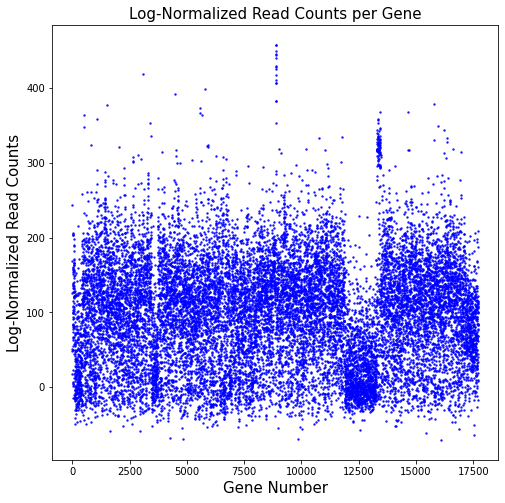

In [0]:
log_norm_test_sums = log_normalized_tmm_test_genes.sum(axis = 0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(range(len(log_norm_test_sums)), log_norm_test_sums, 'b.', alpha = .75, markersize=3)
ax.set_xlabel('Gene Number', size=15)
ax.set_ylabel('Log-Normalized Read Counts', size=15)
ax.set_title('Log-Normalized Read Counts per Gene', size=15)
plt.show()

#### Remove genes eliminated by variance and covariance filters

In [0]:
high_var_gene_indices = list(high_var_train_genes.columns) 
cols_filtered = [x for x in log_normalized_tmm_test_genes.columns if x in high_var_gene_indices]
high_var_processed_test_genes = log_normalized_tmm_test_genes[cols_filtered]

high_var_processed_test_genes.head()

,0,2,4,7,15,28,31,32,33,38,39,42,43,44,45,47,50,55,56,61,62,64,65,66,67,68,69,70,78,79,82,86,88,89,96,98,102,103,106,107,...,24150,24155,24156,24160,24163,24164,24165,24168,24184,24191,24202,24203,24207,24214,24215,24220,24223,24224,24237,24244,24253,24255,24256,24260,24261,24271,24272,24273,24277,24283,24285,24288,24291,24296,24308,24309,24313,24316,24317,24323
0,3.718240,6.844731,0.444856,0.240036,2.647412,2.401787,6.365997,3.042142,2.686068,-0.598213,5.352453,0.334673,-1.513324,1.853248,2.566846,2.357393,0.766784,0.486676,2.951718,0.379761,0.652014,-0.861247,-0.320679,-1.216342,3.853248,0.357393,2.701689,-1.285055,3.571712,-2.642607,-1.998751,0.000000,3.182352,-0.914687,3.447505,3.539787,3.871121,2.576561,2.569281,2.955445,...,3.726990,2.155055,3.252211,2.423482,3.407242,5.262404,4.764129,0.979445,1.233910,0.444856,-0.199664,1.845233,2.816825,-0.302757,0.098860,-0.233216,1.428855,5.421462,0.015604,-1.057645,3.334673,1.934822,3.167965,4.260522,2.640481,0.942355,-2.057645,1.363018,-1.835252,-1.216342,1.942355,-1.285055,5.259014,1.600567,3.363018,0.071638,-1.183175,2.544745,5.482484,6.609763
1,3.390902,5.066514,1.475171,0.535292,4.354515,3.485367,6.933323,4.682687,3.805262,1.827473,6.329089,5.118618,-1.619986,0.786831,1.036060,2.894041,0.218263,1.946645,3.779599,4.720404,1.495491,3.133281,2.349640,3.176398,5.088000,3.687663,2.310034,0.193601,0.859182,-0.963940,0.380014,-1.664380,4.275199,-2.494455,1.149401,2.532837,1.782703,4.414438,2.532837,2.321462,...,0.666537,-2.020524,0.928077,0.324305,1.500527,4.251499,3.403054,0.630241,-0.188647,1.774412,-1.049670,1.254483,-0.140818,-0.272063,0.103804,-0.020524,-1.576917,2.895953,0.935533,-0.806399,3.400363,-0.757490,2.060134,0.444144,-3.857025,2.346847,-1.806399,0.675470,-0.306828,3.255973,4.185807,0.077087,7.185514,-1.535097,2.503038,0.008045,2.865050,1.867001,4.022120,5.906661
2,2.455208,6.811613,0.814963,2.257906,3.130112,6.179645,7.832641,4.924140,2.602865,1.727852,7.737082,1.576514,0.826190,1.763330,3.652591,2.967247,-0.230841,2.706746,1.589750,-1.430150,2.806485,0.622318,0.257906,1.501463,5.837330,3.282568,2.077058,0.859357,3.870245,1.290696,1.429673,0.583147,5.151469,0.207280,4.726355,4.712052,5.214241,4.723355,2.842869,4.662803,...,2.494443,-0.035290,0.709780,-0.015112,2.647853,3.384818,3.288668,1.933904,1.422293,1.666712,-1.097575,1.837330,-0.076513,0.190002,-1.140643,-0.758773,0.274394,3.936496,1.870245,0.118743,3.202980,0.733826,0.792243,2.004787,0.792243,1.641511,2.211567,3.125575,-1.661475,1.429673,2.619094,1.786506,5.832119,0.660453,1.786506,1.306816,0.000000,1.515402,1.820587,5.908710
3,2.460355,6.282357,1.544148,0.848787,2.361162,4.919787,7.110047,3.375212,3.768800,1.169250,6.412075,1.034090,-0.281412,2.243544,4.457356,2.892071,-0.281412,1.765894,2.017898,1.974928,2.961445,-0.380947,-0.707175,1.653000,5.152290,2.363726,1.619053,1.298198,4.047712,0.677946,1.376482,-0.563811,4.504023,0.484123,3.896506,5.056458,4.622805,3.460355,1.431307,4.613676,...,2.316848,-0.188302,0.686167,-0.347000,3.003168,2.819192,3.202583,1.631877,1.431307,0.811698,1.121553,1.694341,0.788978,-3.773265,-0.433415,0.271129,2.663447,3.610440,1.441054,0.512138,2.616904,1.059625,-0.330321,2.237963,1.366287,1.913236,2.127602,1.381553,-1.866374,1.340478,1.796591,2.999875,5.118519,2.221089,2.566585,1.665527,-0.265470,1.361162,1.930639,4.732051
4,1.892628,6.181764,1.853739,0.797471,2.283483,4.724979,7.615835,1.038479,4.072749,1.861601,6.195437,1.158218,0.659967,2.783054,3.232857,3.652056,0.813772,2.092927,1.930496,2.021034,2.662220,0.641820,-0.553437,-0.170108,6.050136,1.888786,1.726056,1.196020,3.595427,1.138939,0.326724,-0.731224,4.887342,1.482697,3.904093,5.000707,4.145394,3.644101,1.730356,4.375586,...,2.593068,0.507964,1.183529,1.262852,2.646378,3.558417,3.219153,2.174089,1.934229,1.789250,1.086232,2.052285,1.552358,0.517948,-0.707765,1.343664,1.996250,4.037611,2.280554,1.132455,3.057428,2.138939,0.414855,2.155023,-0.492036,1.462160,2.035007,1.436071,0.315319,0.623441,1.092927,2.379698,5.232857,2.20222